In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Add


In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPrices.csv')

In [3]:
data.head()

,Date,Price
0,2023-04-03,84.930000
1,2023-04-04,84.940002
2,2023-04-05,84.989998
3,2023-04-06,85.120003
4,2023-04-10,84.180000


In [4]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

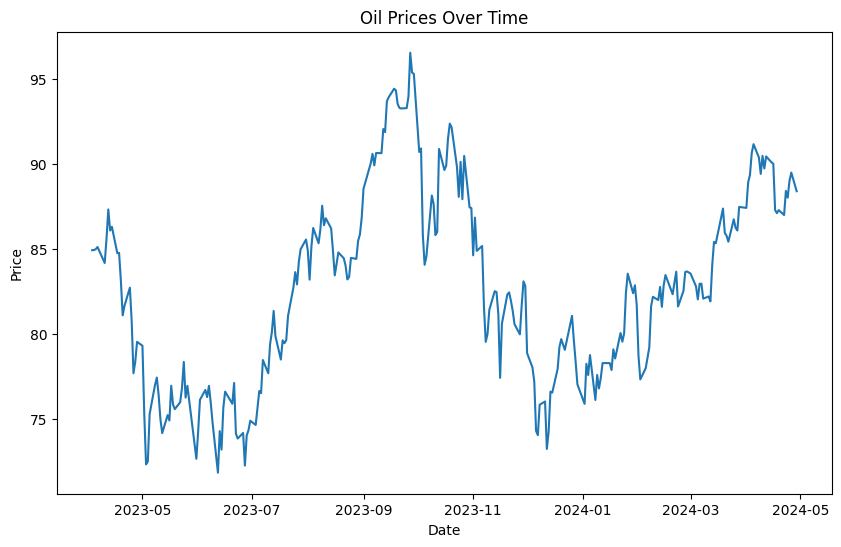

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

In [7]:
# Create sequences for Transformer
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [8]:
seq_length = 60
X, Y = create_sequences(data['Price'].values, seq_length)

In [11]:
# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

In [12]:
# Reshape X for Transformer [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
# 3. Build the Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [14]:
def build_transformer_model(seq_length, d_model, num_heads, ff_dim, num_transformer_blocks, rate=0.1):
    inputs = Input(shape=(seq_length, 1))
    x = Dense(d_model)(inputs)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(d_model, num_heads, ff_dim, rate)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
d_model = 64
num_heads = 4
ff_dim = 64
num_transformer_blocks = 2
rate = 0.1

In [16]:
model1 = build_transformer_model(
    seq_length, 
    d_model, 
    num_heads, 
    ff_dim, 
    num_transformer_blocks,
    rate
)
model1.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 dense (Dense)               (None, 60, 64)            128       
                                                                 
 transformer_block (Transfo  (None, 60, 64)            74944     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 60, 64)            74944     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [18]:
# 4. Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history1 = model1.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 7s 259ms/step - loss: 2.6797 - val_loss: 0.4614 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 125ms/step - loss: 0.5223 - val_loss: 0.2065 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 107ms/step - loss: 0.2653 - val_loss: 0.3194 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1s 114ms/step - loss: 0.2908 - val_loss: 0.0129 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 1s 117ms/step - loss: 0.2397 - val_loss: 0.0201 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 1s 109ms/step - loss: 0.1990 - val_loss: 0.0968 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 1s 144ms/step - loss: 0.1674 - val_loss: 0.0373 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 1s 153ms/step - loss: 0.1831 - val_loss: 0.0188 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 1s 108ms/step - loss: 0.1377 - val_loss: 0.0405 - lr:

In [19]:
# 5. Evaluate the model
train_predict = model1.predict(X_train)
test_predict = model1.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


2/2 [==============================] - 0s 22ms/step


In [20]:
print('Model 01:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 01:
Train Mean Absolute Error: 5.086100623721168
Train Root Mean Squared Error: 5.962078420266844
Test Mean Absolute Error: 2.403026669524437
Test Root Mean Squared Error: 2.8068870454051935


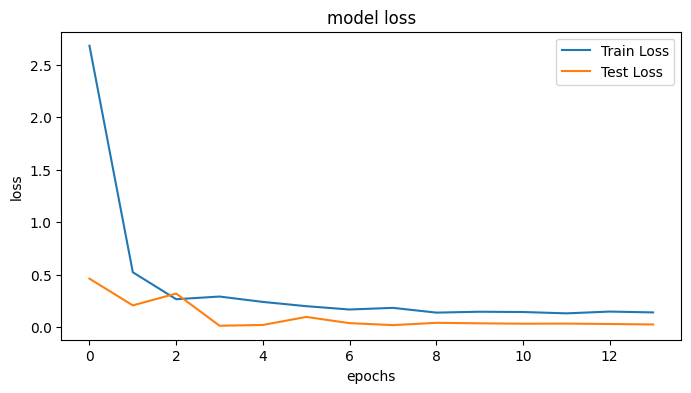

In [21]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs1/transformer model 01 model loss.png')
plt.show()

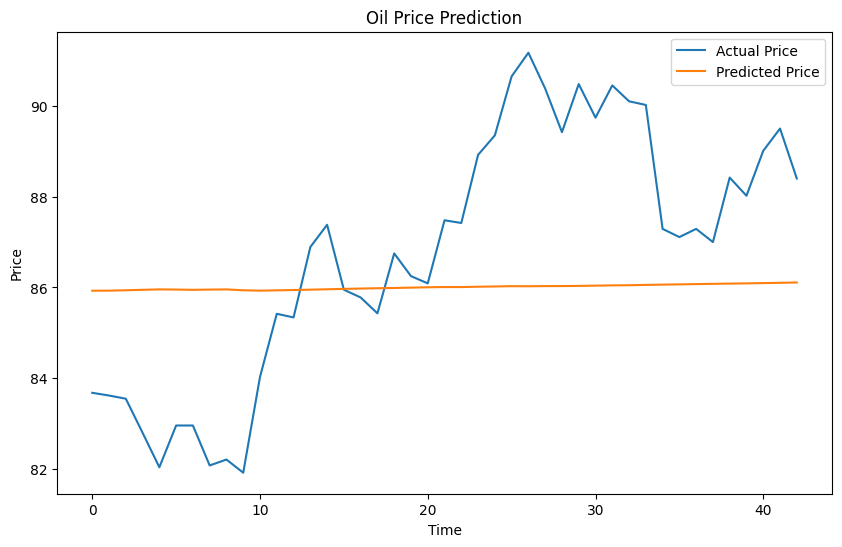

In [22]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs1/transformer model 01 Oil Price Prediction.png')
plt.show()

In [23]:
model1.save('models/Transformer_01.h5') 

# returns a compiled model
# identical to the previous one
# model1 = load_model('my_model.h5')

C:\Users\wgras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
d_model = 64
num_heads = 16
ff_dim = 64
num_transformer_blocks = 8
rate = 0.1

In [25]:
# Build the transformer model
model2  = build_transformer_model(
    seq_length, 
    d_model, 
    num_heads, 
    ff_dim, 
    num_transformer_blocks,
    rate
)

In [26]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 dense_6 (Dense)             (None, 60, 64)            128       
                                                                 
 transformer_block_2 (Trans  (None, 60, 64)            273856    
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  (None, 60, 64)            273856    
 formerBlock)                                                    
                                                                 
 transformer_block_4 (Trans  (None, 60, 64)            273856    
 formerBlock)                                                    
                                                           

In [27]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history2 = model2.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 34s 2s/step - loss: 5900.6343 - val_loss: 5865.9014 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 9s 2s/step - loss: 5386.0522 - val_loss: 5775.1738 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 5301.2539 - val_loss: 5691.5356 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 10s 2s/step - loss: 5230.1685 - val_loss: 5622.7051 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 10s 2s/step - loss: 5169.9941 - val_loss: 5551.6685 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 10s 2s/step - loss: 5104.4312 - val_loss: 5479.4092 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 10s 2s/step - loss: 5030.4717 - val_loss: 5408.1255 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 10s 2s/step - loss: 4948.8018 - val_loss: 5332.7246 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 10s 2s/step - loss: 48

In [31]:
# Evaluate the model
train_predict = model2.predict(X_train)
test_predict = model2.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


2/2 [==============================] - 1s 198ms/step


In [32]:
print('Model 02:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 02:
Train Mean Absolute Error: 118.61319908330863
Train Root Mean Squared Error: 154.01461557942426
Test Mean Absolute Error: 164.61587069666166
Test Root Mean Squared Error: 178.03557637180592


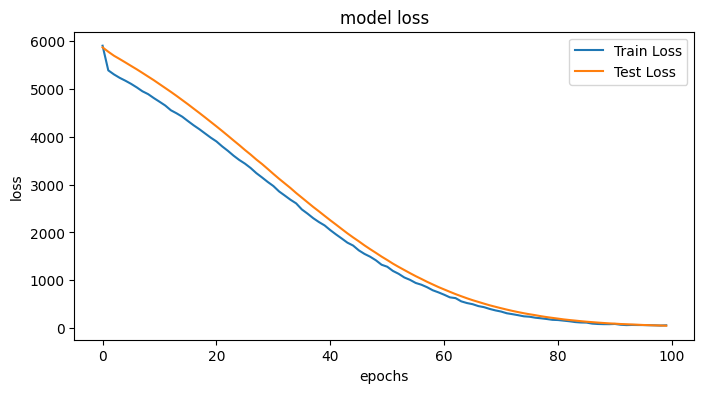

In [34]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs1/transformer model 02 model loss.png')
plt.show()

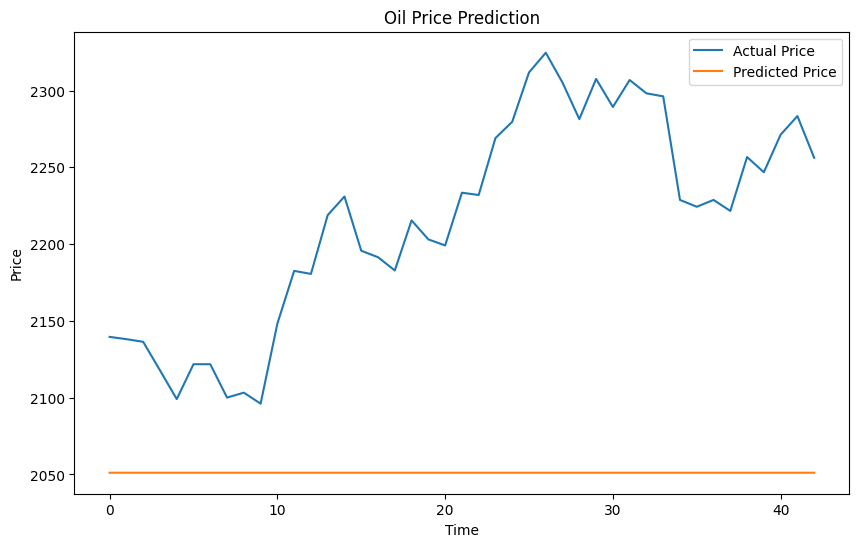

In [35]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs1/transformer model 02 Oil Price Prediction.png')
plt.show()

In [36]:
model2.save('models/Transformer_02.h5') 

# returns a compiled model
# identical to the previous one
# model2 = load_model('my_model.h5')

C:\Users\wgras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
